<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/kfold-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 47 members, which is less than n_splits=48.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 47 members, which is less than n_splits=48.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 47 members, which is less than n_splits=48.
  warnings.warn(
/usr/local/lib/python3.11/dist-pa

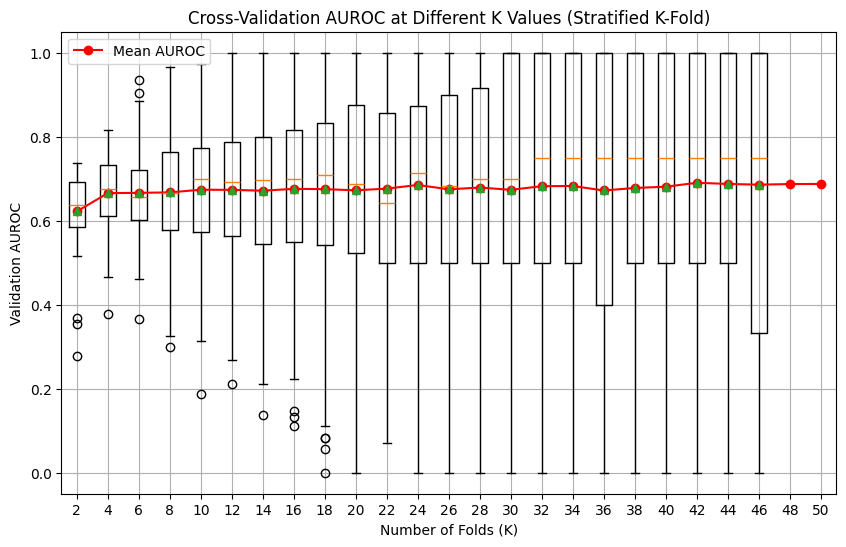

In [53]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from numpy.random import randn
import numpy as np

class DataStreamGenerator:
    """
    A data generator class that produces one example at a time
    with a fixed proportion of positive and negative examples.
    """
    def __init__(self, pos_ratio=0.5, d=2, random_seed=None):
        """
        Initialize the data stream generator.

        Parameters:
        - pos_ratio (float): Proportion of positive examples (0.0 to 1.0).
        - d (int): Dimensionality of the data (number of features).
        - random_seed (int or None): Random seed for reproducibility.
        """
        assert 0 <= pos_ratio <= 1, "pos_ratio must be between 0 and 1."
        self.pos_ratio = pos_ratio
        self.d = d
        self.random_seed = random_seed
        if random_seed is not None:
            np.random.seed(random_seed)

    def generate_example(self):
        """
        Generate a single example (one data point).

        Returns:
        - x (numpy.ndarray): Feature vector of shape (d,).
        - y (int): Label (+1 for positive, -1 for negative).
        """
        if np.random.rand() < self.pos_ratio:
            # Generate a positive example
            x = randn(self.d) + 1
            y = +1
        else:
            # Generate a negative example from one of two clusters
            if np.random.rand() < 0.5:
                x = randn(self.d) - 1  # Cluster 1
            else:
                x = randn(self.d) + 2  # Cluster 2
            y = -1
        return x, y

    def generate_batch(self, n):
        """
        Generate a batch of examples.

        Parameters:
        - n (int): Number of examples to generate.

        Returns:
        - X (numpy.ndarray): Feature matrix of shape (n, d).
        - Y (numpy.ndarray): Labels array of shape (n,).
        """
        X, Y = [], []
        for _ in range(n):
            x, y = self.generate_example()
            X.append(x)
            Y.append(y)
        return np.array(X), np.array(Y)

    def __repr__(self):
        """
        Representation of the DataStreamGenerator object.
        """
        return (f"DataStreamGenerator(pos_ratio={self.pos_ratio}, "
                f"d={self.d}, random_seed={self.random_seed})")


import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Initialize the data generator
generator = DataStreamGenerator(pos_ratio=0.2, d=2, random_seed=42)

# Generate training and testing data
X_train, y_train = generator.generate_batch(200)

# Function to evaluate cross-validation accuracy and AUROC with skipping and stratified KFold
def evaluate_kfold_auroc_svm(X_train, y_train, max_k=10, skip=2, num_runs=5):
    all_fold_aurocs = {}

    for k in range(2, max_k + 1, skip):  # Skip every other K based on the `skip` parameter
        kfold_aurocs = []

        for run in range(num_runs):  # Perform multiple runs
            skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42 + run)

            fold_aurocs = []

            # Perform stratified K-fold cross-validation
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                # Train an SVM model
                model = SVC(C=10.0, kernel='rbf', gamma=1.0, probability=True)
                model.fit(X_train_fold, y_train_fold)

                # Predict probabilities for validation fold
                y_val_pred = model.predict_proba(X_val_fold)[:, 1]
                fold_aurocs.append(roc_auc_score(y_val_fold, y_val_pred))

            kfold_aurocs.extend(fold_aurocs)

        all_fold_aurocs[k] = kfold_aurocs

    return all_fold_aurocs

# Function to plot the box plot and compute AUROC on the test set
def plot_kfold_aurocs(all_fold_aurocs):
    ks = sorted(all_fold_aurocs.keys())
    data = [all_fold_aurocs[k] for k in ks]
    mean_aurocs = [np.nanmean(all_fold_aurocs[k]) for k in ks]

    # Box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=ks, showmeans=True)
    plt.plot(range(1, len(ks) + 1), mean_aurocs, marker='o', linestyle='-', color='red', label='Mean AUROC')
    plt.title('Cross-Validation AUROC at Different K Values (Stratified K-Fold)')
    plt.xlabel('Number of Folds (K)')
    plt.ylabel('Validation AUROC')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate AUROC for K values and plot
max_k = 50  # Maximum K to test
skip = 2    # Skip every other K
num_runs = 20  # Number of runs
all_fold_aurocs = evaluate_kfold_auroc_svm(X_train, y_train, max_k=max_k, skip=skip, num_runs=num_runs)
plot_kfold_aurocs(all_fold_aurocs)



In [55]:
import numpy as np
average_aurocs = {}
for k, aurocs in all_fold_aurocs.items():
    average_aurocs[k] = np.nanmean(aurocs)

# Print the results
for k, avg_auroc in average_aurocs.items():
    print(f"Average AUROC for k={k}: {avg_auroc:.4f}")

Average AUROC for k=2: 0.6220
Average AUROC for k=4: 0.6657
Average AUROC for k=6: 0.6664
Average AUROC for k=8: 0.6675
Average AUROC for k=10: 0.6738
Average AUROC for k=12: 0.6736
Average AUROC for k=14: 0.6715
Average AUROC for k=16: 0.6759
Average AUROC for k=18: 0.6752
Average AUROC for k=20: 0.6724
Average AUROC for k=22: 0.6764
Average AUROC for k=24: 0.6851
Average AUROC for k=26: 0.6747
Average AUROC for k=28: 0.6790
Average AUROC for k=30: 0.6736
Average AUROC for k=32: 0.6823
Average AUROC for k=34: 0.6827
Average AUROC for k=36: 0.6720
Average AUROC for k=38: 0.6780
Average AUROC for k=40: 0.6809
Average AUROC for k=42: 0.6904
Average AUROC for k=44: 0.6876
Average AUROC for k=46: 0.6859
Average AUROC for k=48: 0.6873
Average AUROC for k=50: 0.6876


In [56]:
# Train the final model
final_model = SVC(C=10.0, kernel='rbf', gamma=1.0, probability=True)
final_model.fit(X_train, y_train)
test_aurocs = []
test_size = 2000
num_runs = 20
for _ in range(num_runs):
    # Generate a new test set for each run
    X_test, y_test = generator.generate_batch(test_size)
    # Predict decision function and calculate AUROC
    y_test_pred = final_model.decision_function(X_test)
    test_auroc = roc_auc_score(y_test, y_test_pred)
    test_aurocs.append(test_auroc)

# Calculate mean and standard deviation
mean_auroc = np.mean(test_aurocs)
std_auroc = np.std(test_aurocs)

print(f"Test AUROC (Mean over {num_runs} runs): {mean_auroc:.4f}")
print(f"Test AUROC (Standard Deviation over {num_runs} runs): {std_auroc:.4f}")


Test AUROC (Mean over 20 runs): 0.7560
Test AUROC (Standard Deviation over 20 runs): 0.0102


Bootstrap AUROC (Mean): 0.6520
Bootstrap AUROC (Std): 0.0597


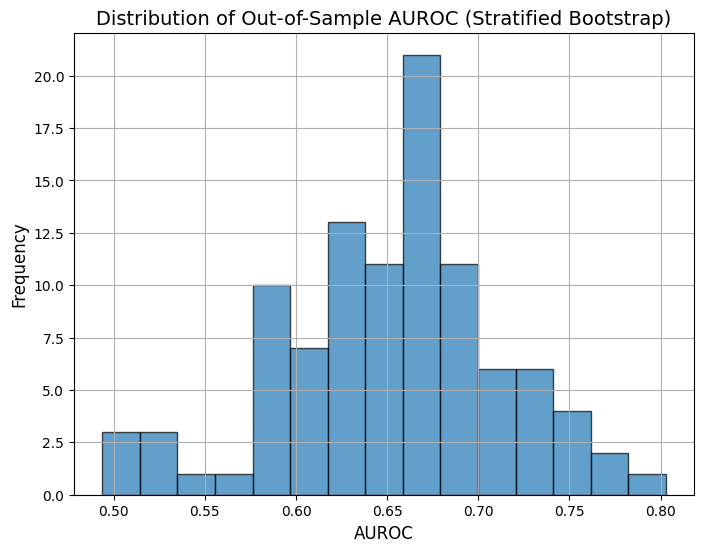

In [57]:
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def stratified_bootstrap_auroc(X_train, y_train, num_iterations=100):
    """
    Perform stratified bootstrap to estimate AUROC on out-of-sample data.

    Parameters:
    - X_train (np.ndarray): Training features.
    - y_train (np.ndarray): Training labels.
    - num_iterations (int): Number of bootstrap iterations.

    Returns:
    - auroc_scores (list): List of AUROC scores from each bootstrap iteration.
    """
    auroc_scores = []

    for i in range(num_iterations):
        # Perform stratified bootstrap resampling
        indices = np.arange(len(y_train))
        resampled_indices = resample(indices, stratify=y_train, random_state=42 + i)

        # Identify the out-of-sample indices
        out_of_sample_mask = np.ones(len(y_train), dtype=bool)
        out_of_sample_mask[resampled_indices] = False
        out_of_sample_indices = np.where(out_of_sample_mask)[0]

        # Skip this iteration if the out-of-sample set is empty
        if len(out_of_sample_indices) == 0:
            continue

        X_resampled = X_train[resampled_indices]
        y_resampled = y_train[resampled_indices]
        X_out_of_sample = X_train[out_of_sample_indices]
        y_out_of_sample = y_train[out_of_sample_indices]

        # Train an SVM model on the resampled data
        model = SVC(C=10.0, kernel='rbf', gamma=1.0, probability=True)
        model.fit(X_resampled, y_resampled)

        # Evaluate AUROC on the out-of-sample data
        y_pred_out_of_sample = model.predict_proba(X_out_of_sample)[:, 1]
        auroc = roc_auc_score(y_out_of_sample, y_pred_out_of_sample)
        auroc_scores.append(auroc)

    return auroc_scores

# Run stratified bootstrap to estimate AUROC
num_iterations = 100  # Number of bootstrap iterations
bootstrap_aurocs = stratified_bootstrap_auroc(X_train, y_train, num_iterations=num_iterations)

# Print and plot the results
print(f"Bootstrap AUROC (Mean): {np.mean(bootstrap_aurocs):.4f}")
print(f"Bootstrap AUROC (Std): {np.std(bootstrap_aurocs):.4f}")

plt.figure(figsize=(8, 6))
plt.hist(bootstrap_aurocs, bins=15, edgecolor='k', alpha=0.7)
plt.title("Distribution of Out-of-Sample AUROC (Stratified Bootstrap)", fontsize=14)
plt.xlabel("AUROC", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


In [58]:
# Calculate the two-tailed p-value
p_left = np.sum(np.array(bootstrap_aurocs) <= test_auroc) / len(bootstrap_aurocs)
p_right = np.sum(np.array(bootstrap_aurocs) >= test_auroc) / len(bootstrap_aurocs)
p_value = 2 * min(p_left, p_right)

print(f"Two-tailed p-value: {p_value:.4f}")


Two-tailed p-value: 0.0800
